In [40]:
import random
import math
import torch
import copy
import pickle
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [41]:
# ======================================
# Prepare Data
def make_batch(data, batch_size, window_size, shuffle=True):
    window_list = []
    for i in range(len(data) - window_size - 1):
        window = data[i: i + window_size]
        window_list.append(window)

    if shuffle:
        random.shuffle(window_list)

    n_batch = math.ceil(len(window_list) / batch_size)
    batch_list = []
    for i in range(n_batch):
        batch = window_list[i*batch_size: (i+1)*batch_size]
        batch_list.append(batch)
    batch_list = np.array(batch_list)

    return batch_list

#data = pd.read_csv("./all_normaldata.tsv", sep='\t', index_col=False)
data = pd.read_csv("./normal.csv", sep=',', index_col=False)
cpu_data = pd.read_csv("./CPU_metric_full.csv", sep=',', index_col=False)
ram_data = pd.read_csv("./Memory_metric_full.csv", sep=',', index_col=False)

#test = pd.read_csv("./Network_metric_full.csv", sep=',', index_col=False)
data = data.to_numpy()
cpu_data = cpu_data.to_numpy()
ram_data = ram_data.to_numpy()
network_data = network_data.to_numpy()

In [42]:
#scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()

In [43]:
data = scaler.fit_transform(data)
cpu_data = scaler.fit_transform(cpu_data)
ram_data = scaler.fit_transform(ram_data)
network_data = scaler.fit_transform(network_data)

In [44]:
# ======================================
# Modeling
class SequenceModel(nn.Module):
    def __init__(self, input_size=1796, output_dim=1796, hidden_size=256, num_layers=1):
        super(SequenceModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.scaler_bias = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.scaler = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = (x + self.scaler_bias) * self.scaler
        zs, hidden = self.lstm(x)
        z = zs[:, -1]
        v = self.linear(zs)
        return v, z

In [45]:
# ======================================
# Training
window_size = 10
batch_size = 192
hidden_size = 128
use_cuda = True

model = SequenceModel(input_size=4585,
                      output_dim=4585,
                      hidden_size=hidden_size,
                      num_layers=1)

if use_cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

n_epoch = 1000
ema_loss = None
alpha = 0.1
verbose_interval = 50

In [46]:
for epoch_i in range(n_epoch):

    batch_list = make_batch(data, batch_size, window_size+1)
    for batch_i, batch in enumerate(batch_list):
        optimizer.zero_grad()

        batch = np.array(batch)
        batch_input = batch[:, :-1, :]
        batch_output = batch[:, 1:, :]

        batch_input = torch.tensor(batch_input, dtype=torch.float32)
        batch_output = torch.tensor(batch_output, dtype=torch.float32)

        if use_cuda:
            batch_input = batch_input.cuda()
            batch_output = batch_output.cuda()
        
        v, _ = model(batch_input)

        loss = loss_fn(v, batch_output)

        loss.backward()
        optimizer.step()

        if ema_loss is None:
            ema_loss = loss.item()
        ema_loss = loss.item() * alpha + (1.-alpha) * ema_loss

    if epoch_i % verbose_interval == 0:
        print(f"{epoch_i}th epoch, loss: {ema_loss}")

0th epoch, loss: 0.2472286383924496
50th epoch, loss: 0.13476748345825923
100th epoch, loss: 0.09320844898331575
150th epoch, loss: 0.07351255458898234
200th epoch, loss: 0.07037049018941285
250th epoch, loss: 0.06873470504826341
300th epoch, loss: 0.06633299059809271
350th epoch, loss: 0.06578717486232473
400th epoch, loss: 0.06479829327826589
450th epoch, loss: 0.06533300882630762
500th epoch, loss: 0.0642614840746649
550th epoch, loss: 0.06405446729635211
600th epoch, loss: 0.06493589435492374
650th epoch, loss: 0.06377000386323295
700th epoch, loss: 0.06341071336215502
750th epoch, loss: 0.06349427032536462
800th epoch, loss: 0.06375963291219479
850th epoch, loss: 0.06407467352817296
900th epoch, loss: 0.06418543552407668
950th epoch, loss: 0.06368193945188416


In [55]:
# ======================================
# Inference
model.eval()
model.cpu()


# Prepare train data distribution
Z = []
reconstruction_error = []

batch_list = make_batch(data, batch_size, window_size, False)
for batch_i, batch in enumerate(batch_list):
    batch = np.array(batch)
    batch_input = batch

    batch_input = torch.tensor(batch_input, dtype=torch.float32)
    batch_output = torch.tensor(batch_output, dtype=torch.float32)

    v, z = model(batch_input)

    Z.extend(z.tolist())
    reconstruction_error.extend(torch.sum(torch.abs(v-batch_input), dim=[1,2]).detach().tolist())

Z = np.array(Z)
reconstruction_error = np.array(reconstruction_error)

/home/ubuntu/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [58]:
sample_pos = data[0:9]
sample_neg_cpu = cpu_data
sample_neg_ram = ram_data
sample_neg_network = network_data

print(sample_neg_cpu)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [80]:
# Samples for quering

sample_pos = data
sample_neg_cpu = cpu_data[50:59] 
sample_neg_ram = ram_data[30:39] 
sample_neg_network = network_data[30:39]

sample_pos = np.array(sample_pos)  # sequence_length x featbure size
sample_pos = torch.tensor(sample_pos, dtype=torch.float32)  # sequence_length x feature size
sample_pos = sample_pos.unsqueeze(0)  # 1 x sequence_length x feature size
prediction_pos, z_prime_pos = model(sample_pos)

# neg_cpu
sample_neg_cpu = np.array(sample_neg_cpu)  # sequence_length x feature size
sample_neg_cpu = torch.tensor(sample_neg_cpu, dtype=torch.float32)  # sequence_length x feature size
sample_neg_cpu = sample_neg_cpu.unsqueeze(0)  # 1 x sequence_length x feature size
prediction_neg_cpu, z_prime_neg_cpu = model(sample_neg_cpu)

# neg_ram
sample_neg_ram = np.array(sample_neg_ram)  # sequence_length x feature size
sample_neg_ram = torch.tensor(sample_neg_ram, dtype=torch.float32)  # sequence_length x feature size
sample_neg_ram = sample_neg_ram.unsqueeze(0)  # 1 x sequence_length x feature size
prediction_neg_ram, z_prime_neg_ram = model(sample_neg_ram)

# neg_network
sample_neg_network = np.array(sample_neg_network)  # sequence_length x feature size
sample_neg_network = torch.tensor(sample_neg_network, dtype=torch.float32)  # sequence_length x feature size
sample_neg_network = sample_neg_network.unsqueeze(0)  # 1 x sequence_length x feature size
prediction_neg_network, z_prime_neg_network = model(sample_neg_network)

z_prime_pos = z_prime_pos.detach().numpy()
z_prime_neg_cpu = z_prime_neg_cpu.detach().numpy()
z_prime_neg_ram = z_prime_neg_ram.detach().numpy()
z_prime_neg_network = z_prime_neg_network.detach().numpy()

reconstruction_error_pos = torch.sum(torch.abs(prediction_pos[:, -1:,:] - sample_pos[:, :-1, :]), dim=[1,2]).detach().tolist()
reconstruction_error_neg_cpu = torch.sum(torch.abs(prediction_neg_cpu[:, -1:,:] - prediction_neg_cpu[:, :-1, :]), dim=[1,2]).detach().tolist()
reconstruction_error_neg_ram = torch.sum(torch.abs(prediction_neg_ram[:, -1:,:] - prediction_neg_ram[:, :-1, :]), dim=[1,2]).detach().tolist()
reconstruction_error_neg_network = torch.sum(torch.abs(prediction_neg_network[:, -1:,:] - prediction_neg_network[:, :-1, :]), dim=[1,2]).detach().tolist()

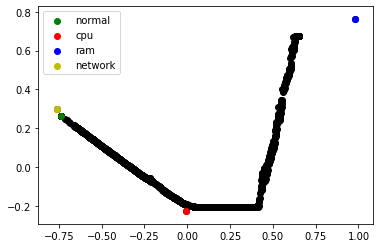

In [81]:
# ======================================
# Visualize latent space
pca = PCA(n_components=2)

Z_for_PCA = copy.deepcopy(Z)
Z_for_PCA = np.concatenate( [Z_for_PCA, z_prime_neg_cpu])
Z_for_PCA = np.concatenate( [Z_for_PCA, z_prime_neg_ram])
Z_for_PCA = np.concatenate( [Z_for_PCA, z_prime_neg_network])

pca.fit(Z_for_PCA)


Z_2d = pca.transform(Z_for_PCA)
z_prime_pos_2d = pca.transform(z_prime_pos)
z_prime_neg_2d_cpu = pca.transform(z_prime_neg_cpu)
z_prime_neg_2d_ram = pca.transform(z_prime_neg_ram)
z_prime_neg_2d_network = pca.transform(z_prime_neg_network)

plt.scatter(Z_2d[:, 0], Z_2d[:, 1], color='k')
plt.scatter(z_prime_pos_2d[:, 0],z_prime_pos_2d[:, 1] , color='g', label='normal')
plt.scatter(z_prime_neg_2d_cpu[:, 0],z_prime_neg_2d_cpu[:, 1] , color='r', label='cpu')
plt.scatter(z_prime_neg_2d_ram[:, 0],z_prime_neg_2d_ram[:, 1] , color='b', label='ram')
plt.scatter(z_prime_neg_2d_network[:, 0],z_prime_neg_2d_network[:, 1] , color='y', label='network')
plt.legend()
plt.show()

In [79]:
dist1 = pairwise_distances(z_prime_neg_cpu, z_prime_neg_ram)
dist2 = pairwise_distances(z_prime_neg_cpu, z_prime_neg_network)
dist3 = pairwise_distances(z_prime_neg_ram, z_prime_neg_network)
print(dist1)
print(dist2)
print(dist3)

[[0.11107632]]
[[0.26390916]]
[[0.15464324]]


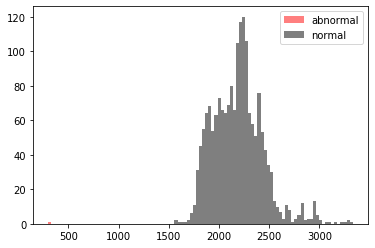

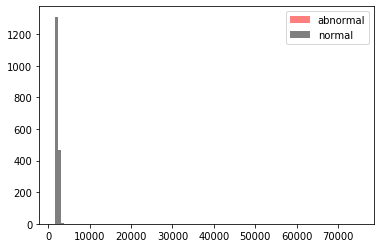

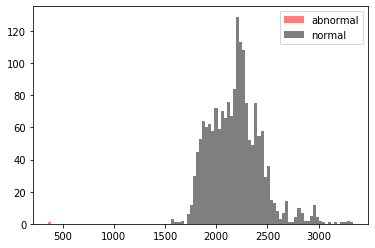

In [67]:
# ======================================
# Plot Reconstruction Error 
neg_height = 1

min_val = min(min(reconstruction_error), min(reconstruction_error_neg_cpu))
max_val = max(max(reconstruction_error), max(reconstruction_error_neg_cpu))
bins = np.linspace(min_val, 
                   max_val,
                   100)
##CPU
plt.hist(reconstruction_error_neg_cpu * neg_height, bins=bins, alpha=0.5, color='red', label='abnormal')
plt.hist(reconstruction_error, bins=bins, alpha=0.5,color='k', label='normal')
plt.legend()
plt.show()

min_val = min(min(reconstruction_error), min(reconstruction_error_neg_ram))
max_val = max(max(reconstruction_error), max(reconstruction_error_neg_ram))
bins = np.linspace(min_val, 
                   max_val,
                   100)

##RAM
plt.hist(reconstruction_error_neg_ram * neg_height, bins=bins, alpha=0.5, color='red', label='abnormal')
plt.hist(reconstruction_error, bins=bins, alpha=0.5,color='k', label='normal')
plt.legend()
plt.show()


##Network
min_val = min(min(reconstruction_error), min(reconstruction_error_neg_network))
max_val = max(max(reconstruction_error), max(reconstruction_error_neg_network))
bins = np.linspace(min_val, 
                   max_val,
                   100)

plt.hist(reconstruction_error_neg_network * neg_height, bins=bins, alpha=0.5, color='red', label='abnormal')
plt.hist(reconstruction_error, bins=bins, alpha=0.5,color='k', label='normal')
plt.legend()
plt.show()



In [83]:
rce_std = np.std(reconstruction_error)
rce_mean = np.mean(reconstruction_error)
print(rce_std,rce_mean)

248.89149854287155 2187.0138351815926


In [ ]:
#######PDF calculation###########

def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [ ]:
x = 
normpdf(x, rce_mean, rce_std)

In [ ]:
P(recon_error=1600) = 0.4

In [ ]:
reconstruction_error

In [ ]:
reconstruction_error_neg

In [ ]:
import pickle

In [ ]:
# Data Load
torch.save(model.state_dict(), "ckpt/model.ckpt")

with open("./ckpt/Z.pickle", "wb") as f:
    pickle.dump(Z, f)

In [ ]:
with open("./ckpt/scaler.pickle", "wb") as f:
    pickle.dump(scaler, f)

In [ ]:
meta = ['정상'] * 50 + ['cpu때문'] * 50  +['비정상'] * 6

In [ ]:
with open("./ckpt/Z_meta.pickle", "wb") as f:
    pickle.dump(meta, f)

In [ ]:
Z.shape

# Use

In [ ]:
# ======================================
# Modeling
class SequenceModel(nn.Module):
    def __init__(self, input_size=1796, output_dim=1796, hidden_size=256, num_layers=1):
        super(SequenceModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.scaler_bias = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.scaler = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = (x + self.scaler_bias) * self.scaler
        zs, hidden = self.lstm(x)
        z = zs[:, -1]
        v = self.linear(zs)
        return v, z

In [ ]:
model = SequenceModel(input_size=4585,
                      output_dim=4585,
                      hidden_size=hidden_size,
                      num_layers=1)

In [ ]:
model.load_state_dict(torch.load( "ckpt/model.ckpt"))

In [ ]:
with open("./ckpt/Z.pickle", "rb") as f:
    Z = pickle.load(f)

In [ ]:
Z

In [ ]:

sample_neg = data[46:55] + np.random.random( data[46:55].shape).reshape(9, 4585) * 0.1

sample_neg = np.array(sample_neg)  # sequence_length x feature size
sample_neg = torch.tensor(sample_neg, dtype=torch.float32)  # sequence_length x feature size
sample_neg = sample_neg.unsqueeze(0)  # 1 x sequence_length x feature size
prediction_neg, z_prime_neg = model(sample_neg)

z_prime_neg = z_prime_neg.detach().numpy()

reconstruction_error_neg = torch.sum(torch.abs(prediction_neg[:, -1:,:] - sample_neg[:, :-1, :]), dim=[1,2]).detach().tolist()

In [ ]:
input_ = sample_neg

In [ ]:
batch_input.shape

In [ ]:
batch_input.dtype

In [ ]:
sample_neg.shape

In [ ]:
pairwise_distances()

In [ ]:
f(x_t+1, x_t+2, x_t+3,.. x_t+999 |x_t, x_t-1, x_t-2)